In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import EarlyStopping
from keras import backend as K
from tabulate import tabulate
from tensorflow import keras
from kerastuner import Hyperband, Objective


C:\Users\Alon\AppData\Local\Temp\ipykernel_22304\3353479080.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import Hyperband, Objective


In [2]:
f = 'weatherHistory.csv'

weather = pd.read_csv(f)
weather.head(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


In [3]:
weather['Formatted Date'] = pd.to_datetime(weather['Formatted Date'], utc=True)

# Set 'Formatted Date' as index
weather.set_index('Formatted Date', inplace=True)

weather = weather.sort_index()

In [4]:
# If the dtype is not datetime64, convert it to datetime
weather.index = pd.to_datetime(weather.index)
# Check the data type of the index
print(weather.index.dtype)

datetime64[ns, UTC]


In [5]:
missing_values = weather.isnull().sum()
print(missing_values)
weather['Precip Type'].unique()



Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


array(['rain', 'snow', nan], dtype=object)

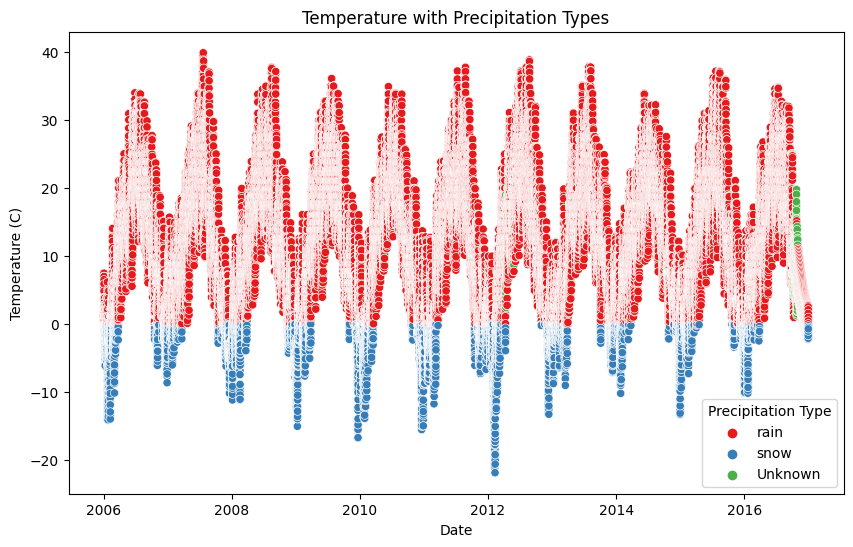

In [6]:
# Fill NaN values in 'Precip Type' column with a placeholder, for example 'Unknown'
weather['Precip Type'].fillna('Unknown', inplace=True)

plt.figure(figsize=(10, 6))

# Using Seaborn scatterplot
sns.scatterplot(data=weather, x=weather.index, y='Temperature (C)', hue='Precip Type', palette='Set1')

plt.title('Temperature with Precipitation Types')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend(title='Precipitation Type')
plt.show()

In [7]:
# Drop columns
weather.drop(columns=['Apparent Temperature (C)', 'Precip Type', 'Loud Cover', 'Daily Summary'], inplace=True)

# Verify changes
print(weather.head())

                                 Summary  Temperature (C)  Humidity  \
Formatted Date                                                        
2005-12-31 23:00:00+00:00  Partly Cloudy         0.577778      0.89   
2006-01-01 00:00:00+00:00  Mostly Cloudy         1.161111      0.85   
2006-01-01 01:00:00+00:00  Mostly Cloudy         1.666667      0.82   
2006-01-01 02:00:00+00:00       Overcast         1.711111      0.82   
2006-01-01 03:00:00+00:00  Mostly Cloudy         1.183333      0.86   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2005-12-31 23:00:00+00:00            17.1143                   140.0   
2006-01-01 00:00:00+00:00            16.6152                   139.0   
2006-01-01 01:00:00+00:00            20.2538                   140.0   
2006-01-01 02:00:00+00:00            14.4900                   140.0   
2006-01-01 03:00:00+00:00            13.9426                   134.0  

In [8]:
wind_degrees = weather['Wind Bearing (degrees)']

# Define function to map wind bearings to categories
def map_wind_direction(degrees):
    directions = ['N', 'NNE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    degree_ranges = [(348.75, 11.25), (11.25, 33.75), (33.75, 56.25), (56.25, 78.75), (101.25, 123.75),
                     (123.75, 146.25), (146.25, 168.75), (168.75, 191.25), (191.25, 213.75), (213.75, 236.25),
                     (236.25, 258.75), (258.75, 281.25), (281.25, 303.75), (303.75, 326.25), (326.25, 348.75)]
    for direction, (start, end) in zip(directions, degree_ranges):
        if start <= degrees < end:
            return direction
    return directions[0]  # Default to 'N' if not in any range

# Map wind direction
weather['Wind Direction'] = weather['Wind Bearing (degrees)'].apply(map_wind_direction)

# Perform one-hot encoding
weather = pd.get_dummies(weather, columns=['Wind Direction'], prefix='Wind', drop_first=True)

# Drop original 'Wind Bearing (degrees)' column
weather.drop(columns=['Wind Bearing (degrees)'], inplace=True)

weather['Summary'].unique()

weather_summary = weather['Summary']

# Perform one-hot encoding for 'Summary' column
weather = pd.get_dummies(weather, columns=['Summary'], prefix='Summary', drop_first=True)

# Extract month and hour from datetime index
weather['Month'] = weather.index.month
weather['Hour'] = weather.index.hour

# Perform one-hot encoding for 'Month' and 'Hour' columns
weather = pd.get_dummies(weather, columns=['Month'], prefix='Month', drop_first=True)
weather = pd.get_dummies(weather, columns=['Hour'], prefix='Hour', drop_first=True)


# Verify changes
print(weather.head())

                           Temperature (C)  Humidity  Wind Speed (km/h)  \
Formatted Date                                                            
2005-12-31 23:00:00+00:00         0.577778      0.89            17.1143   
2006-01-01 00:00:00+00:00         1.161111      0.85            16.6152   
2006-01-01 01:00:00+00:00         1.666667      0.82            20.2538   
2006-01-01 02:00:00+00:00         1.711111      0.82            14.4900   
2006-01-01 03:00:00+00:00         1.183333      0.86            13.9426   

                           Visibility (km)  Pressure (millibars)  Wind_ENE  \
Formatted Date                                                               
2005-12-31 23:00:00+00:00           9.9820               1016.66         0   
2006-01-01 00:00:00+00:00           9.9015               1016.15         0   
2006-01-01 01:00:00+00:00           9.9015               1015.87         0   
2006-01-01 02:00:00+00:00           9.9015               1015.56         0   
2006-0

### Dataset Construction

In [9]:
# Define window size (number of time steps to consider)
window_size = 24 * 3  # 3 days (24 hours each)

# Function to create input-output pairs from time series data
def create_dataset(X, y, window_size):
    X_data, y_data = [], []
    for i in range(len(X) - window_size - 23):  # Adjust loop range to stop before reaching the last observation
        X_data.append(X[i:i+window_size])
        # Append the next 24 observations (1 day) to y_data
        y_data.append(y[i+window_size:i+window_size+24])
    return np.array(X_data), np.array(y_data)

# Prepare input-output pairs
X, y = create_dataset(weather.values, weather['Temperature (C)'].values, window_size)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Exclude dummy variables from scaling
continuous_columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
X_train_continuous = X_train[:, :, :len(continuous_columns)]
X_test_continuous = X_test[:, :, :len(continuous_columns)]

# Scale continuous features
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous.reshape(-1, X_train_continuous.shape[-1])).reshape(X_train_continuous.shape)
X_test_continuous_scaled = scaler.transform(X_test_continuous.reshape(-1, X_test_continuous.shape[-1])).reshape(X_test_continuous.shape)

# Combine scaled continuous features with dummy variables
X_train_scaled = np.concatenate((X_train_continuous_scaled, X_train[:, :, len(continuous_columns):]), axis=-1)
X_test_scaled = np.concatenate((X_test_continuous_scaled, X_test[:, :, len(continuous_columns):]), axis=-1)

In [11]:
# Reshape data for LSTM input (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, -1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, -1)

# Split data into train and validation sets
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, shuffle=False)

### Model

In [25]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Model moved to tuning
# # Build LSTM model
# model = Sequential()
# model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.03)))
# model.add(BatchNormalization())
# model.add(Dense(32,"relu", kernel_regularizer=l2(0.03)))
# model.add(BatchNormalization())
# model.add(Dense(32,"relu", kernel_regularizer=l2(0.03)))
# model.add(Dense(units=24))
# model.compile(optimizer='rmsprop', 
#               loss='mse',
#               metrics=['mae', rmse, r_squared])
# model.summary()


In [13]:
def build_lstm_model(hp):
  # Define search space for hyperparameters
  optimizer = hp.Choice('optimizer', ['rmsprop', 'adam'])
  loss = hp.Choice('loss', ['mse', 'mae'])
  lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
  dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)

  # Build LSTM model with hyperparameters
  model = Sequential()
  model.add(LSTM(units=lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(BatchNormalization())
  model.add(Dense(units=dense_units, activation="relu"))
  model.add(BatchNormalization())
  model.add(Dense(units=dense_units, activation="relu"))
  model.add(Dense(units=24))
  model.compile(optimizer=optimizer, loss=loss)
  return model


In [14]:
# Define tuner with Hyperband search algorithm

objective = Objective("val_loss", direction="min")

tuner = Hyperband(
    build_lstm_model,
    objective=objective,
    max_epochs=50,
    project_name='lstm_tuning'
)

# Fit the tuner
tuner.search(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val))

# Get the best model0
best_model = tuner.get_best_models()[0]

best_model.summary()

Trial 81 Complete [00h 16m 36s]
val_loss: 5.918685436248779

Best val_loss So Far: 1.674951195716858
Total elapsed time: 12h 46m 01s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                14336     
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 128)               

In [34]:
for key, value in best_hps.values.items():
    print(key, ':', value)

{'optimizer': 'adam',
 'loss': 'mae',
 'lstm_units': 32,
 'dense_units': 128,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0034'}

In [36]:
# Get best hyperparamers
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimizer = best_hps.get('optimizer')
loss = best_hps.get('loss')
epochs = best_hps.get('tuner/epochs')

# Define EarlyStopping callback 
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the best_model with the desired metrics
best_model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

# Train the best model with early stopping using validation data
history = best_model.fit(X_train_scaled, y_train, epochs=epochs,
              validation_data=(X_val_scaled, y_val))

Epoch 1/17
1928/1928 [==============================] - 44s 21ms/step - loss: 1.1039 - rmse: 1.3718 - val_loss: 2.1199 - val_rmse: 2.4997
Epoch 2/17
1928/1928 [==============================] - 37s 19ms/step - loss: 1.1031 - rmse: 1.3709 - val_loss: 2.0857 - val_rmse: 2.4596
Epoch 3/17
1928/1928 [==============================] - 37s 19ms/step - loss: 1.0938 - rmse: 1.3604 - val_loss: 2.1329 - val_rmse: 2.5062
Epoch 4/17
1928/1928 [==============================] - 41s 21ms/step - loss: 1.0866 - rmse: 1.3533 - val_loss: 2.1042 - val_rmse: 2.4802
Epoch 5/17
1928/1928 [==============================] - 37s 19ms/step - loss: 1.0784 - rmse: 1.3442 - val_loss: 2.1276 - val_rmse: 2.4990
Epoch 6/17
1928/1928 [==============================] - 34s 18ms/step - loss: 1.0689 - rmse: 1.3335 - val_loss: 2.1527 - val_rmse: 2.5381
Epoch 7/17
1928/1928 [==============================] - 34s 18ms/step - loss: 1.0668 - rmse: 1.3318 - val_loss: 2.1638 - val_rmse: 2.5374
Epoch 8/17
1928/1928 [============

In [37]:
# Extract one before the last 74 hours of X_test_scaled
X_test_last_74_hours = X_test_scaled[-1:, :]

# Make predictions based on the last 3-day window
predictions = best_model.predict(X_test_last_74_hours)

# Initialize a list to store rows of the table
table_data = []

# Get the date and time for the current prediction from the original DataFrame
date_time = weather.index[-24:].strftime('%Y-%m-%d %H:%M')

# Append a row to the table_data list containing date-time, predicted values, and actual values
for j in range(24):
    table_data.append([date_time[j], predictions[0][j], y_test[-1][j], y_test[-1][j] - predictions[0][j]])

# Define column headers
headers = ['Date-Time', 'Predicted', 'Actual', 'Distance']

# Print the table using tabulate
print(tabulate(table_data, headers=headers, tablefmt="grid"))



1/1 [==============================] - 0s 409ms/step
+------------------+-------------+------------+------------+
| Date-Time        |   Predicted |     Actual |   Distance |
+==================+=============+============+============+
| 2016-12-30 23:00 |   -0.301995 | -0.872222  |  -0.570227 |
+------------------+-------------+------------+------------+
| 2016-12-31 00:00 |   -0.246101 | -1.16111   |  -0.91501  |
+------------------+-------------+------------+------------+
| 2016-12-31 01:00 |   -0.442362 | -1.48889   |  -1.04653  |
+------------------+-------------+------------+------------+
| 2016-12-31 02:00 |   -0.657682 | -1.82222   |  -1.16454  |
+------------------+-------------+------------+------------+
| 2016-12-31 03:00 |   -0.656794 | -2.07778   |  -1.42098  |
+------------------+-------------+------------+------------+
| 2016-12-31 04:00 |   -0.679878 | -2.17778   |  -1.4979   |
+------------------+-------------+------------+------------+
| 2016-12-31 05:00 |   -0.397051

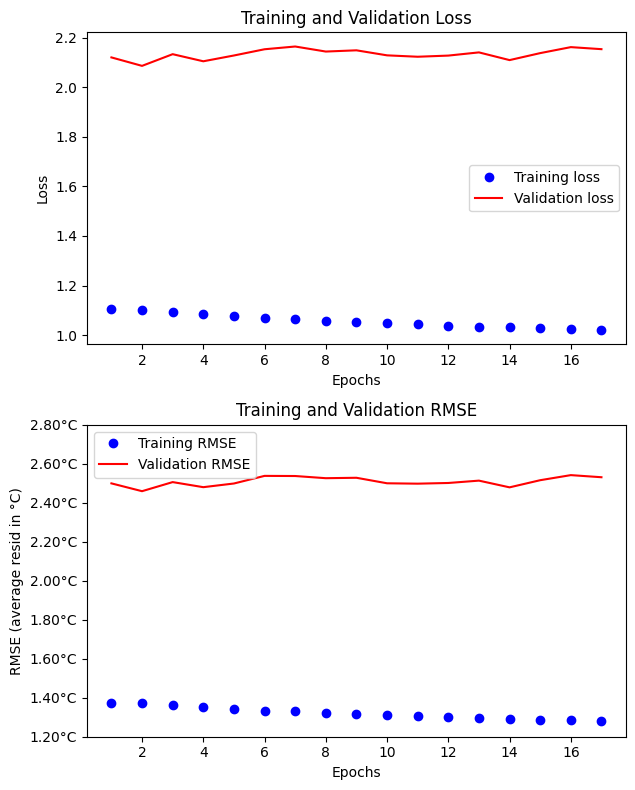

In [38]:
# Extract metrics from history
loss_metric = history.history['loss']
val_loss_metric = history.history['val_loss']
rmse_metric = history.history['rmse']
val_rmse_metric = history.history['val_rmse']

# Plot training and validation loss
epochs = range(1, len(loss_metric) + 1)
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_metric, 'bo', label='Training loss')
plt.plot(epochs, val_loss_metric, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(epochs, rmse_metric, 'bo', label='Training RMSE')
plt.plot(epochs, val_rmse_metric, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE (average resid in °C)')
plt.legend()

# Add degree Celsius symbol to y-axis ticks
plt.yticks(plt.gca().get_yticks(), [f'{x:.2f}°C' for x in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()